In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.colors as colors
plt.style.use('seaborn-poster')

import sys, os
from iminuit import Minuit
import numpy as np; import time; from timeout_decorator import timeout,TimeoutError
import scipy.special as sps
from optparse import OptionParser
from scipy.optimize import fsolve, root
import pickle

import env


base_path = os.environ['ANALYSIS_BASE_PATH']
sys.path.append(base_path+'python')

In [2]:
import importlib
halo_spec = importlib.util.find_spec("halo")
halo_found = halo_spec is not None

if halo_found:
    from halo import Halo
    

In [3]:
print (base_path)

/data/ana/BSM/HT_Cascade/FinalAnalysisCode/


In [4]:
LEmasses = [40, 63, 100, 158, 251, 398, 631]
HEmasses = [1000, 1585, 2512, 3981, 6310, 10000, 15850, 25120, 39810]

all_masses = np.append(LEmasses,HEmasses)
LECuts = [0.15,0.2]
HECuts = [-1.0,0.3]
mode = "annihilation"
channel = "nue"
profile = "NFW"
systematics = "nominal"

mass = 1000
if mass in LEmasses:
    LECut,HECut = LECut
else:
    LECut,HECut = HECuts
print (LECut, HECut)
nOversampling = 100

bins_merge_E   = 2
bins_merge_Psi  = 9


-1.0 0.3


In [5]:
systematics_DM = 'nominal'

DM_file_template = '/PDF_'+systematics_DM+'_DM'+mode+'_'+profile+'profile_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+    '_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling'+str(nOversampling)

print (DM_file_template)

/PDF_nominal_DMannihilation_NFWprofile_LEBDT-1.0_HEBDT0.3_2D_nue_1000GeV_oversampling100


In [6]:
h_DM = np.load(base_path+'PDFs/'+mode+'/'+channel+'/'+systematics_DM+DM_file_template+'.pkl', allow_pickle = True, encoding='latin1')
h_DM_quad = np.load(base_path+'PDFs/'+mode+'/'+channel+'/'+systematics_DM+DM_file_template+'_quad.pkl', allow_pickle=True, encoding='latin1')

h_signal_scrambled = np.load(base_path+'PDFs/ScrambledSignal/'+mode+'/'+'/PDF_DM_FullSkyScrambled_'+mode+'_'+profile+'profile_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+'_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling'+str(100)+'.pkl','r', allow_pickle=True, encoding='latin1')
h_signal_scrambled_quad = np.load(base_path+'PDFs/ScrambledSignal/'+mode+'/'+'/PDF_DM_FullSkyScrambled_'+mode+'_'+profile+'profile_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+'_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling'+str(100)+'_quad.pkl','r', allow_pickle=True, encoding='latin1')

In [7]:
print (base_path+'PDFs/ScrambledSignal/'+mode+'/'+'/PDF_DM_FullSkyScrambled_'+mode+'_'+profile+'profile_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+'_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling'+str(100)+'.pkl')

/data/ana/BSM/HT_Cascade/FinalAnalysisCode/PDFs/ScrambledSignal/annihilation//PDF_DM_FullSkyScrambled_annihilation_NFWprofile_LEBDT-1.0_HEBDT0.3_2D_nue_1000GeV_oversampling100.pkl


In [8]:
bkg_type = 'data'
print ("Loading the histograms... with bkg_type: %s"%bkg_type)
bkg_file = base_path+'PDFs/Data_scrambledFullSky/PDF_Data_ScrambleFullSky_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+'_2D'
bkg_file_quad = bkg_file
h_Bkg = np.load(bkg_file+'.pkl','r', allow_pickle=True, encoding='latin1')
h_Bkg_quad = h_Bkg

Loading the histograms... with bkg_type: data


In [9]:
from utils import merge_bins

In [10]:
#####################
#
# all PDFs are in units of events!
#
#####################
time_tot     = 28272940. + 30674072. + 31511810.5 + 31150852. + 30059465.
#time_tot = 1.
hDM     = merge_bins(h_DM, time_tot,bins_merge_E, bins_merge_Psi)
hDM_quad    = merge_bins(h_DM_quad, time_tot**2,bins_merge_E, bins_merge_Psi) 
#hDM_quad[0][hDM_quad[0]==0] = 9.

hSignalScram = merge_bins(h_signal_scrambled, time_tot,bins_merge_E, bins_merge_Psi)
hSignalScram_quad = merge_bins(h_signal_scrambled_quad, time_tot**2,bins_merge_E, bins_merge_Psi)

In [11]:
hbkg    = merge_bins(h_Bkg, 1.,bins_merge_E, bins_merge_Psi) 
    #hbkg[0][hbkg[0]==0] = 1.
hbkg_quad   = merge_bins(h_Bkg_quad, 1.,bins_merge_E, bins_merge_Psi)



#np.shape(np.array(hatm)[2])

fig,axs = plt.subplots(2,2,figsize=(30,30))
pcm = axs[0,0].pcolormesh(hbkg[2],hbkg[1],hbkg[0])
fig.colorbar(pcm, ax=axs[0,0], label='rate (Hz)')
axs[0,0].set_title("Scrambled Data", fontsize=30)
axs[0,0].set_xlabel(r"$\Psi_{\mathrm{reco}}$ (rad)")
axs[0,0].set_ylabel(r"E$_{\mathrm{reco}}$ (GeV)")
axs[0,0].set_yscale('log')

pcm = axs[0,1].pcolormesh(hDM[2],hDM[1],hDM[0])
fig.colorbar(pcm, ax=axs[0,1], label='rate (Hz)')
axs[0,1].set_title("DM signal", fontsize=30)
axs[0,1].set_xlabel(r"$\Psi_{\mathrm{reco}}$ (rad)")
axs[0,1].set_ylabel(r"E$_{\mathrm{reco}}$ (GeV)")
axs[0,1].set_yscale('log')

pcm = axs[1,0].pcolormesh(hSignalScram[2],hSignalScram[1],hSignalScram[0])
fig.colorbar(pcm, ax=axs[1,0], label='rate (Hz)')
axs[1,0].set_title("DM signal scrambled", fontsize=30)
axs[1,0].set_xlabel(r"$\Psi_{\mathrm{reco}}$ (rad)")
axs[1,0].set_ylabel(r"E$_{\mathrm{reco}}$ (GeV)")
axs[1,0].set_yscale('log')

pcm = axs[1,1].pcolormesh(hDM[2],hDM[1],hDM[0])
fig.colorbar(pcm, ax=axs[1,1], label='rate (Hz)')
axs[1,1].set_title(r"Dark Matter $\chi\chi \rightarrow \nu_e \nu_e$ 100 GeV")

axs[1,1].set_xlabel(r"$\Psi_{\mathrm{reco}}$ (rad)")
axs[1,1].set_ylabel(r"E$_{\mathrm{reco}}$ (GeV)")
axs[1,1].set_yscale('log')

In [12]:
print (np.sum(hbkg_quad[0]), np.sum(hSignalScram_quad[0]), np.sum(hDM_quad[0]))

22165.0 1696.2861917293415 4714.823730073624


In [13]:
#Let's correct the normalization of hSignalScram I will figure out later why is not the same

hSignalScrambled = np.array(hSignalScram[0])/np.sum(hSignalScram[0])*np.sum(hDM[0])



In [14]:
    
#-----------------------------#
#    use SimpleLLHanalyser    #
#-----------------------------#
import LLHAnalyser
                                                 
analysis = LLHAnalyser.Profile_Analyser_Normalised()
analysis.saveMoreOutput()

analysis.loadBackgroundPDF(np.array(hbkg[0]), True)
analysis.loadSignalPDF(np.array(hDM[0]))


LLH_type = 'Effective'
#LLH_type = 'PoissonWithSignalSubtraction'

#analysis.loadSignalScrambledPDF(np.array(hSignalScram[0]))    

analysis.loadSignalScrambledPDF(hSignalScrambled)    

if LLH_type == 'Effective':
    analysis.loadUncertaintyPDFs(np.array(hbkg_quad[0]),np.array(hDM_quad[0]))
    analysis.allowNegativeSignal()
    
elif LLH_type == 'PoissonWithSignalSubtraction':
    analysis.loadSignalScrambledPDF(np.array(hSignalScram[0]))    

elif LLH_type == 'EffectiveWithSignalSubtraction':
    analysis.loadUncertaintyPDFs(np.array(hbkg_quad[0]),np.array(hDM_quad[0]))
    analysis.loadSignalScrambledPDF(np.array(hSignalScram[0]))
    analysis.loadSignalScrambledUncertaintyPDF(np.array(hSignalScram_quad[0]))    
    
print ("Using %s likelihood method"%LLH_type)
analysis.setLLHtype(LLH_type)

Total number of expected background events: 22165.0
Initalizing the baseline pdf
 Allowing for negative signal
Using Effective likelihood method


In [15]:
print (analysis.AllowNegativeSignal)

True


In [16]:
#analysis.allowNegativeSignal()

In [17]:
Ntrials = 1000
sens = analysis.CalculateSensitivity(Ntrials, 90)

In [18]:
print('Median sensitivity xi=',sens['median'])
print('Median sensitivity xs=',sens['median']*np.sum(hbkg[0])/np.sum(hDM[0])*10**-23)

Median sensitivity xi= 0.002339543615342641
Median sensitivity xs= 4.515842692448362e-25


In [20]:
analysis.evaluateLLH(0.1)-analysis.evaluateLLH(0)


238.06967442811583

In [21]:
print(sens['TS_dist'])
print("Median TS", np.percentile(sens['TS_dist'], 50))

[0.0, 0.0, 0.03824232003535144, 2.3427304621145595, 0.0, 0.0, 0.0, 0.0390614727512002, 0.0, 0.419522173673613, 0.13076005774200894, 2.8026196673163213, 0.19413733642431907, 0.0, 0.05213406923576258, 0.2115693593514152, 0.0, 0.0, 0.0, 0.1031175140524283, 0.0, 0.0, 0.0, 0.0, 0.0, 2.773864700924605, 0.2357929722056724, 0.0, 0.004605149384588003, 1.209424834116362, 0.0, 0.017520687339128926, 0.0, 0.0, 0.04740845653577708, 1.4344045808247756, 1.8596799149527214, 0.01092482783133164, 0.34238031262066215, 1.8196190797898453, 0.0, 0.05442417153972201, 0.6135901876259595, 1.4470701974641997, 0.82567084627226, 0.24630905970116146, 0.18788568046875298, 0.2749206258158665, 1.0244969954364933, 0.0, 0.4374167902569752, 0.13237199425930157, 0.20838280199677683, 0.0, 0.13594324470614083, 0.5662518956523854, 0.0, 0.0, 0.8767591336218175, 0.1186906268412713, 0.0, 0.11408977361861616, 0.0, 0.0, 0.0, 0.26504302938701585, 0.0, 0.0, 0.0, 0.0006667560955975205, 0.7043883943115361, 0.386137078050524, 0.056065


Median TS 0.0022403849434340373


#We want a precison of 90 +/- 1 %
mean, sens_neyman = analysis.CalculateFrequentistSensitivity(90, 0.5)

In [22]:
TS_sens = next(s['TS_dis'] for s in sens_neyman if s['xi'] == mean)

NameError: name 'sens_neyman' is not defined

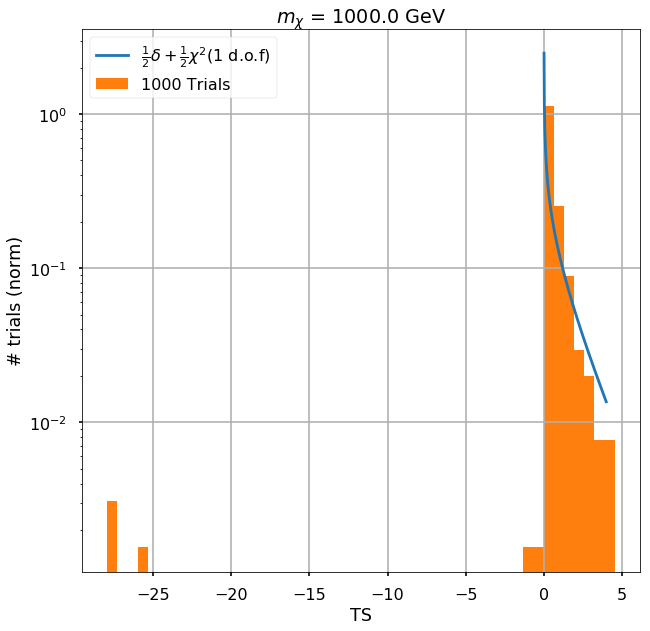

In [20]:
%matplotlib inline
from scipy.stats import chi2
x = np.arange(0, 4, 0.01)
df = 1
rv = chi2(df)

from scipy import signal
imp = signal.unit_impulse(np.size(x),1)

#bins = np.linspace(0, 10, 50)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(x, 0.5*imp + 0.5*rv.pdf(x), label =r"$\frac{1}{2}\delta + \frac{1}{2}\chi^2$(1 d.o.f)")
ax.hist(sens['TS_dist'], 50, density=True, label="%i Trials"%Ntrials)
#ax.hist(TS_sens, bins, density=True, label="%i Trials"%Ntrials, histtype="step", linewidth=5)
ax.set_yscale('log')
ax.set_title(r"$m_\chi$ = %.1f GeV"%mass)
ax.set_ylabel("# trials (norm)")
ax.set_xlabel("TS")
#ax.set_xlim(0,3)
ax.legend()
ax.grid()

In [21]:
print('Median sensitivity xs=',sens['median']*np.sum(hbkg[0])/np.sum(hDM[0])*10**-23)
print('Median Freq sensitivity xs=',mean*np.sum(hbkg[0])/np.sum(hDM[0])*10**-23)

Median sensitivity xs= 4.2653136788603375e-25
Median Freq sensitivity xs= 4.705097645765395e-25
